# Conducción de calor en 1D: <font color=green>Caso No estacionario</font>

**Trabajo realizado con el apoyo del Programa UNAM-DGAPA-PAPIME PE101019**

*   Autores: 
    - Luis M. de la Cruz Salas
*   Rev: lun 15 feb 2021 15:37:48 CST

<img src="./Figuras/conceptualCOMPLETO.png" style="width: 300px;"/>

Estudiar la conducción de calor dependiente del tiempo en una barra metálica.

 <table style="width:100%">
  <tr>
    <th style="text-align:center">Barra metálica</th>
    <th style="text-align:center">Conducción de calor</th>
    <th style="text-align:center">Nodos de simulación</th>
  </tr>
  <tr>
    <td style="text-align:center"><video src="./Videos/01_Conduccion1D.mp4" width="160" controls></video></td>
    <td style="text-align:center"><video src="./Videos/02_Conduccion1D.mp4" width="160" controls></video></td>
    <td style="text-align:center"><video src="./videos/03_Conduccion1D.mp4" width="160" controls></video></td>
  </tr>
  <tr>
    <td style="text-align:center">  </td>
    <td style="text-align:center">Cada color indica una temperatura diferente</td>
    <td style="text-align:center">Se aproximará la solución en cada punto</td>
  </tr>
</table> 
<br>

Propiedades de la barra
1. Longitud: 0.5 m
2. Conductividad térmica ($\kappa$): 1000 W / m K
3. Temperatura constante en el extremo izquierdo: 100 [$^o C$]
4. Temperatura constante en el extremo derecho: 500 [$^o C$]

<img src="./Figuras/matematicoCOMPLETO.png" style="width: 300px;"/>

El modelo matemático de este problema consiste de la siguiente ecuación diferencial parcial:

$
\frac{\partial T}{\partial t} = \frac{\partial}{\partial x} \left(\kappa \frac{\partial T}{\partial x}\right)
$

La solución de esta ecuación implica encontrar la temperatura $T$ en cualquier punto $x$ de la barra y en cualquier tiempo $t$. Es decir, la temperatura es una función de dos variables $T(x,t)$.

Este modelo se completa con las condiciones mostradas en la siguiente figura:

<img src="./Figuras/01_Conduccion1D_BC_IC.png" style="width: 500px;"/>

La barra (representada en gris) tiene una temperatura fija en sus extremos: $T = 100 ^o$C del lado izquierdo y $T = 500 ^o$C del lado derecho. Estas condiciones se conocen como **condiciones de frontera**, pues están en la frontera de la barra.

Además, la temperatura en todos los puntos internos de la barra (línea punteada) inicialmente es de $T = 0 ^o$C. Esto se conoce como la **condición inicial** y será útil para calcular la temperatura en tiempos posteriores.

Adicionalmente, en la figura se puede observar una serie de círculos púrpura, que son los lugares donde se calculará numéricamente la temperatura.

Matemáticamente se puede escribir:

- **Condición inicial** : $T(x, t=0) = 0, \quad \forall x \in (0,1)$
- **Condiciones de frontera** : $T(x=0, t) = TA \quad$ y $\quad T(x=L, t) = TB, \quad \forall t \in [0,Tmax]$.

donde $TA = 100 ^o$C y $TB = 500 ^o$C

<img src="./Figuras/numericoCOMPLETO.png" style="width: 300px;"/>

En este ejemplo haremos la solución de manera implícita y con el método de volumen finito.

<img src="./Figuras/computacionalCOMPLETO.png" style="width: 450px;"/>

Con toda la información anterior, vamos a implementar un algoritmo para obtener la temperatura de la barra en sus puntos interiores y en los instantes de tiempo $n = 1, \dots, $Tmax.


In [64]:
#-----------------------------------------------------------
# PATH ABSOLUTO DE LOS MÓDULOS DE PYNOXTLI
#
import os, sys
sys.path.insert(0, os.path.abspath('../../base'))
#-----------------------------------------------------------

In [65]:
import numpy as np
#
# Importamos los módulos necesarios de PyNoxtli.
#
from geo.line import Line
from utils.displayInfo import printInfo
from fvm.tDiffusion import tDiffusion1D
from fvm.pde import PDE
import vis.flowix as flx

In [66]:
#
# Primero definimos las propiedades físicas y geométricas de la barra:
#
longitud = 0.5 # metros
TA = 100 # °C 
TB = 500 # °C 
k  = 1000 # W/m.K
N  = 6 # Número de nodos
dt = 0.00001 # Paso de tiempo
Tmax = 20 # Número de pasos en el tiempo

In [67]:
#
# Definición del dominio y condiciones de frontera
#
barra = Line(longitud)
barra.boundaryConditions(dirichlet = {'RIGHT':TB, 'LEFT':TA})
#
# Creamos la malla y obtenemos datos importantes
#
malla     = barra.constructMesh(N) # Se construye la malla del dominio.
ivx, _, _ = malla.bounds(bi = 1, ei = N-1) # Se obtienen los grados de libertad
nx        = malla.nx    # Número de nodos
nvx       = malla.vx    # Número de volúmenes
delta     = malla.dx    # Tamaño de los volúmenes

In [68]:
#
# Se generan las coordenadas de la malla para FVM
#
x, _, _ = malla.coordinatesMeshFVM() 
#
# Se calcula la solución analítica sobre los puntos de la malla (x)
#
Ta = 800 * x + 100

In [69]:
#
# Imprimimos los datos del problema (nicely)
#
printInfo(Longitud = longitud,
          Temperatura_A = TA,
          Temperatura_B = TB,
          Conductividad = k,
          Nodos = nx, 
          Volúmenes = nvx,
          Delta = delta,
          dt = dt)

.--------------------------------------------------------------------------------.
|              PyNoxtli : Ver. 0.2, LMCS-2020, [GNU GPL License V3]              |
.--------------------------------------------------------------------------------.
|       Longitud = 5.000000000000000e-01                                         |
|  Temperatura_A =    100                                                        |
|  Temperatura_B =    500                                                        |
|  Conductividad =    1000                                                       |
|          Nodos =     6                                                         |
|      Volúmenes =     5                                                         |
|          Delta = 1.000000000000000e-01                                         |
|             dt = 1.000000000000000e-05                                         |
.--------------------------------------------------------------------------------.


In [76]:
#
# Se construye el arreglo donde se guardará la solución
#
T = np.zeros(nvx+2) # El arreglo contiene ceros
T *= TA          # Inicializamos T = TA
T[0]  = TA       # Condición de frontera izquierda
T[-1] = TB       # Condición de frontera derecha
#
# Definimos la fuente, en este caso es cero.
#
Su = np.zeros(ivx)
#
# Definimos el esquema de disccretización
#
dif_scheme = tDiffusion1D(malla, Su, Gamma = k, dt = dt)
#
# Definimos la ecuación a resolver
#
laplace = PDE(barra, T)
#
# Preparamos el sistema lineal y creamos la matriz
#
laplace.setNumericalScheme(dif_scheme)

Iteraciones : 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 

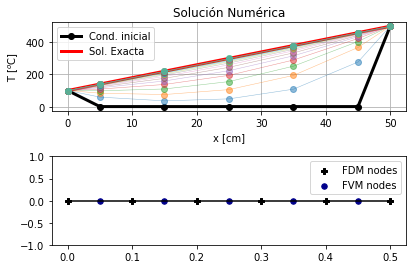

In [77]:
#
# Preparamos la visualización con VisCoFlow
#
axis_par = [{'title':'Solución Numérica', 'xlabel':'x [cm]', 'ylabel':'T [$^o$C]'}]   
v = flx.Plotter(2,1,axis_par)
#
# Se grafica la condición inicial
#
v.plot(1,x * 100,T, {'marker':'o', 'ls':'-', 'lw':3, 'color':'k', 'label':'Cond. inicial'})
#
# Resolvemos para varios pasos de tiempo definidos por Tmax
#
print('Iteraciones :', end = ' ')
for n in range(0,Tmax):
    print(n, end=' ')
    laplace.solve()
    v.plot(1,x * 100,T, {'marker':'o', 'ls':'-', 'lw':0.5, 'zorder':5, 'alpha':0.5})
#
# Se grafica la solución exacta
#
v.plot(1,x * 100,Ta, {'color':'r', 'ls':'-', 'lw':3, 'label':'Sol. Exacta'})
#
# Se grafica la malla del dominio
#
v.plot_mesh(2, malla, label=True)
#
# Se muestran las gráficas
#
v.grid()
v.legend()
v.show()